In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import pickle
import numpy as np
import torch
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import base_network as base_net
import ring_network as network
import sim_util as su
import ricciardi as ric
import integrate as integ

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(imsh, cax=cax, orientation='vertical')
    return cbar

# Extract Best Fit

In [38]:
id = (133, 0)
with open('./../results/results_ring_'+str(id[0])+'.pkl', 'rb') as handle:
    res_dict = pickle.load(handle)[id[1]]
    prms = res_dict['prms']
    eX = res_dict['best_monk_eX']
    bX = res_dict['best_monk_bX']
    aXs = res_dict['best_monk_aXs']
#     K = prms['K']
    SoriE = prms['SoriE']
    SoriI = prms['SoriI']
    SoriF = prms['SoriF']
#     J = prms['J']
#     beta = prms['beta']
#     gE = prms['gE']
#     gI = prms['gI']
#     hE = prms['hE']
#     hI = prms['hI']
#     L = prms['L']
#     CVL = prms['CVL']

ri = ric.Ricciardi()
ri.set_up_nonlinearity('./../scripts/phi_int')
ri.set_up_nonlinearity_tensor()

NtE = 50
Nt = NtE*ri.tE
dt = ri.tI/3
T = torch.linspace(0,3*Nt,round(3*Nt/dt)+1)
mask_time = T>(2*Nt)
T_mask = T.cpu().numpy()[mask_time]

N = 5000
Nori = 20
NE = 4*(N//Nori)//5
NI = 1*(N//Nori)//5

this_prms = prms.copy()
this_prms['Nori'] = Nori
this_prms['NE'] = NE
this_prms['NI'] = NI

Loading previously saved nonlinearity
Using cpu


# Simulate Network with Different Ks

In [46]:
reload(su)
reload(integ)

this_prms['K'] = 200
this_prms['J'] = prms['J'] / np.sqrt(this_prms['K']/500)

start = time.process_time()

net,M,HV,HB,LAS,eps = su.gen_ring_disorder_tensor([0],this_prms,eX)
H = (bX*HB+aXs[-1]*HV)*eps

print("Generating disorder took ",time.process_time() - start," s")
print('')

start = time.process_time()

sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,H,LAS,net.C_conds[0],mult_tau=True,method='rk4')
rates = torch.mean(sol[:,mask_time],axis=1).cpu().numpy()
dynas = sol[:,mask_time].cpu().numpy()

np.save('sol_K={:d}'.format(this_prms['K']),sol.cpu().numpy())

print("Integrating network took ",time.process_time() - start," s")
print('')

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# sol = torch.from_numpy(np.load('sol_K={:d}.npy'.format(this_prms['K']))).to(device)
# rates = torch.mean(sol[:,mask_time],axis=1).cpu().numpy()
# dynas = sol[:,mask_time].cpu().numpy()

Using cpu
Generating disorder took  1.3676159999999982  s

Integrating network took  26.38319  s



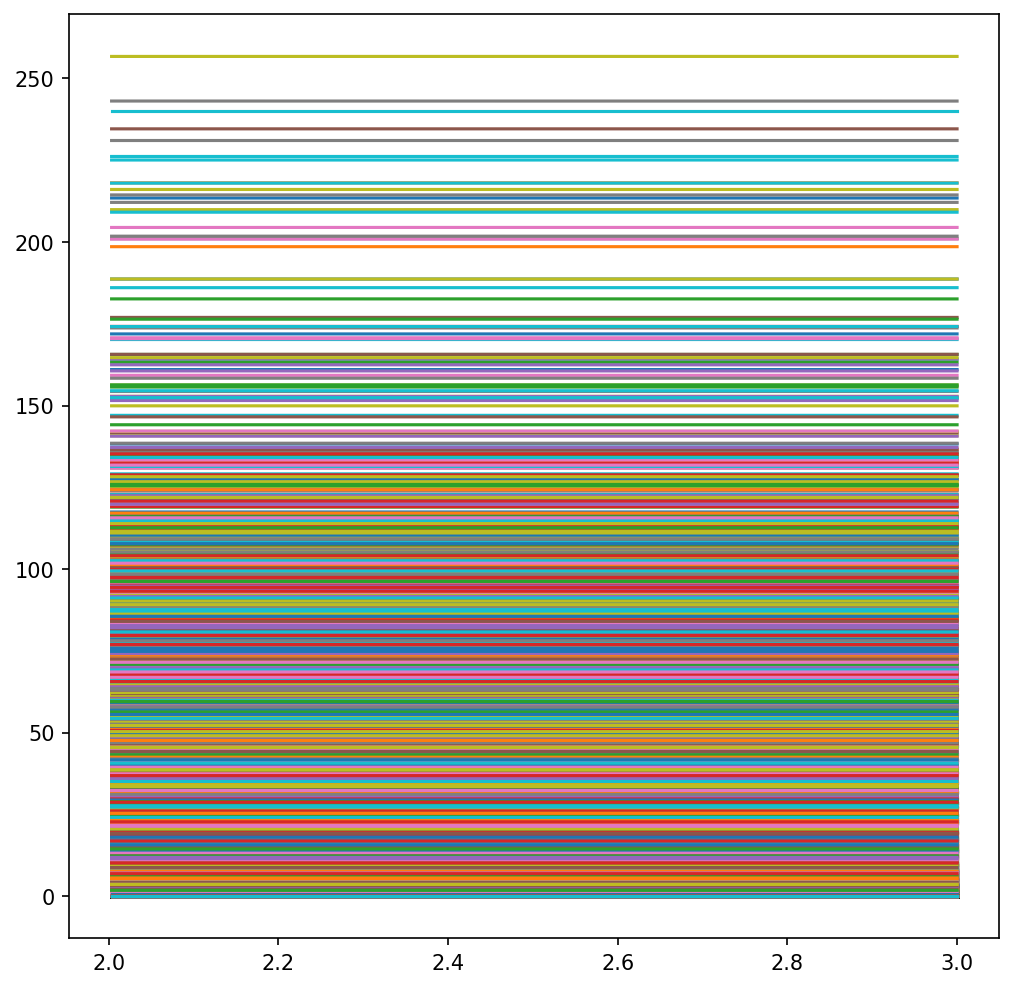

In [47]:
fig,axs = plt.subplots(1,1,figsize=(8,8),dpi=150,sharex=True,sharey=True)

axs.plot(T_mask,dynas.T)

plt.show()

In [48]:
reload(integ)

Ls = integ.calc_lyapunov_exp_tensor(ri,T,0.0,M,H,LAS,net.C_conds[0],sol,
                                   5,2*Nt,2*ri.tE,mult_tau=True)

NWONS = 600
NT = 900
NONS = 12
Initializing Q took 4.4086300000000165 s

Warmup took 10.500320999999985 s

Full Q evolution took 5.441159999999996 s



In [49]:
Ls

tensor([-3.3504, -3.2462, -8.0955, -8.1208, -8.4793], dtype=torch.float64)

In [50]:
np.max(Ls.numpy())

-3.246223308146